In [444]:
import numpy as np
import netrep.metrics as met
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import ttest_ind
from sklearn.manifold import MDS
from sklearn.model_selection import LeaveOneOut, cross_val_score
import itertools
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

In [442]:
def flatten_samples(x, untill=1):
    dims_count=len(x.shape)
    return x.reshape(*x.shape[:-(dims_count- untill)], -1)

In [443]:
def pca_across_batch(x, n_components=None):
    if not n_components:
        n_components=min(x.shape)
    pca=PCA(n_components=n_components)
    pca_x= pca.fit_transform(x)
    return pca_x

def batched_pca(x, n_components=None):
    return  np.array([np.array([pca_across_batch(x[i][j], n_components=n_components) for j in range(x.shape[1])]) for i in range(x.shape[0])])

In [515]:
s32=np.load("S32_mean.npy")
s16=np.load("S16_mean.npy")

In [539]:
s32_all=np.load("S32_all.npy")
s16_all=np.load("S16_all.npy")

In [560]:
s32_all.shape

(26, 3, 84, 28, 502)

## Use if files are _all instead

In [541]:
s32_selected= np.random.choice(range(84), 36, replace=False)

In [542]:
s16=s16_all
s32=s32_all

In [543]:
s32=s32[:, :, s32_selected, :, :]

In [ ]:
s16=s16.reshape(s16.shape[0], s16.shape[1] *s16.shape[2], s16.shape[3], s16.shape[4])
s32= s32.reshape(s32.shape[0], s32.shape[1]*s32.shape[2], s32.shape[3], s32.shape[4])

In [548]:
s32.shape

(26, 108, 28, 502)

# PCA

In [549]:
s16_comp=flatten_samples(batched_pca(s16), 2)

In [550]:
s32_comp=flatten_samples(batched_pca(s32), 2)

In [551]:
s16_comp.shape

(26, 108, 784)

In [552]:
s32_comp.shape

(26, 108, 784)

In [256]:
def create_dist_matrix(lm, X):
    ij=itertools.combinations(range(len(X)), 2)
    dist_matrix = np.zeros((len(X), len(X)))
    for i, j in tqdm(ij):
        score=lm.fit_score(X[i], X[j])
        dist_matrix[i][j]=score              
        dist_matrix[j][i]=score
    return dist_matrix

In [309]:
lm=met.LinearMetric(alpha=0,center_columns=True, score_method="euclidean")
lm_half=met.LinearMetric(alpha=0.5,center_columns=True, score_method="euclidean")
lm_full=met.LinearMetric(alpha=1,center_columns=True, score_method="euclidean")

In [258]:
Xs=np.concatenate((s16_comp, s32_comp))

In [259]:
Xs.shape

(52, 3, 784)

In [310]:
dist_mat_null=create_dist_matrix(lm, Xs)

1326it [02:18,  9.57it/s]


In [311]:
dist_mat_half=create_dist_matrix(lm_half, Xs)

1326it [02:18,  9.60it/s]


In [312]:
dist_mat_full=create_dist_matrix(lm_full, Xs)

1326it [01:09, 19.06it/s]


In [436]:
euclid_dist_m= np.linalg.norm(Xs[:, None, None, :]- Xs[None, :, None, :, :], axis=(2,3)).min(-1)

In [486]:
def get_dists(x):
    same_upp= x[:len(x)//2, : len(x)//2]
    same_lower= x[len(x)//2: , len(x)//2:]
    same=np.concatenate((same_upp[np.triu_indices_from(same_upp, k=0)] , same_lower[np.triu_indices_from(same_lower, k=0)] ) )
    diff= x[len(x)//2:, :len(x)//2].flatten()
    return same, diff

In [330]:
lower_0, upper_0 = get_dists(dist_mat_null)

In [331]:
lower_05, upper_05 = get_dists(dist_mat_half)

In [349]:
lower_1, upper_1 = get_dists(dist_mat_full)

In [350]:
lower_euclid, upper_euclid= get_dists(euclid_dist_m)

In [342]:
ttest_ind(upper_0, lower_0)

TtestResult(statistic=3.263936264748064, pvalue=0.001126275125009384, df=1350.0)

In [344]:
ttest_ind(upper_05, lower_05)

TtestResult(statistic=2.6981386812838215, pvalue=0.007059739264730527, df=1350.0)

In [351]:
ttest_ind( upper_1, lower_1)

TtestResult(statistic=1.5083851951168565, pvalue=0.13169454371662107, df=1324.0)

In [352]:
ttest_ind( upper_euclid,lower_euclid)

TtestResult(statistic=1.0665014830091868, pvalue=0.28639144188704496, df=1324.0)

In [381]:
fig0 = ff.create_distplot([lower_0, upper_0 ], ["Same", "Different"], show_hist=False,curve_type='normal')
fig05 = ff.create_distplot([lower_05, upper_05 ], ["Same", "Different"], show_hist=False,curve_type='normal')
fig1 = ff.create_distplot([lower_1, upper_1 ], ["Same", "Different"], show_hist=False,curve_type='normal')

In [379]:
fig_euc=ff.create_distplot([lower_euclid, upper_euclid ], ["Same", "Different"], show_hist=False,curve_type='normal')

In [ ]:
fig_euc.update_layout(autosize=False, width=400, height=400)

In [553]:
s16_comp_em=s16_comp.reshape(26, 3, 36, 784)
s32_comp_em=s32_comp.reshape(26, 3, 36, 784)

In [554]:
em=met.EnergyStochasticMetric(tol=1e-4)

In [555]:
Xs=np.concatenate((s16_comp_em, s32_comp_em))

In [ ]:
dist_matrix = np.zeros((len(Xs), len(Xs)))
ij=itertools.combinations(range(len(Xs)), 2)
for i, j in tqdm(ij):
    em=met.EnergyStochasticMetric(tol=1e-3)
    score=em.fit_score(Xs[i], Xs[j])
    dist_matrix[i][j]=score              
    dist_matrix[j][i]=score

1305it [1:38:11,  5.69s/it]

In [697]:
lower_en, upper_en = get_dists(dist_matrix)

In [698]:
ttest_ind(lower_en, upper_en)

TtestResult(statistic=-2.6709213824358993, pvalue=0.007653512001589067, df=1376.0)

In [699]:
fig = ff.create_distplot([lower_en, upper_en ], ["Same", "Different"], show_hist=False, curve_type='normal')

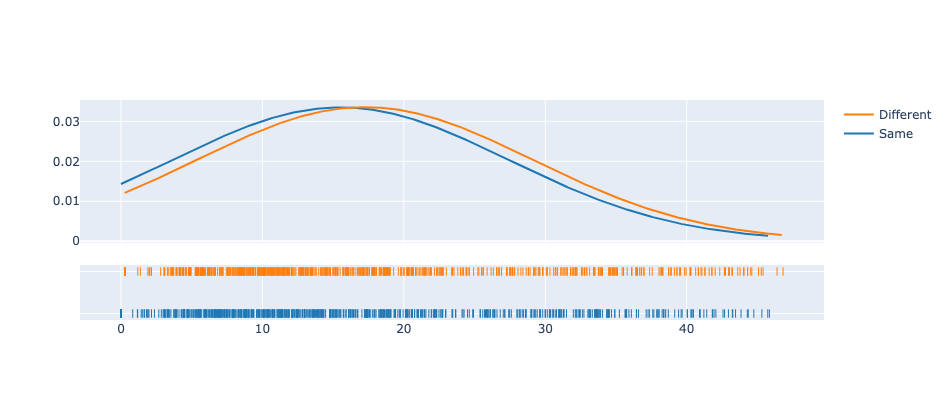

In [700]:
fig.update_layout(autosize=False, width=400, height=400)

# KNN classifier

In [577]:
y= np.array( [0]*26 + [1]*26)

In [385]:
def knn_pred(dist_matrix, y, k=2):
    scores=[]
    for i in range(len(dist_matrix)):
        m=dist_matrix[i]
        _, y_preds= np.unique(y[np.argsort(m)[1:k]], return_counts=True)
        scores.append( y_preds.argmax() == y[i] )

    return np.sum(np.array(scores, dtype=int))/ len(dist_matrix)
        

In [395]:
zero_knn_scores=[]
for k in range(2,50):
    zero_knn_scores.append(knn_pred(dist_mat_null, y, k))

In [396]:
np.max(zero_knn_scores)

0.6153846153846154

In [397]:
np.argmax(zero_knn_scores)

23

In [386]:
half_knn_scores=[]
for k in range(2,50):
    half_knn_scores.append(knn_pred(dist_mat_half, y, k))

In [398]:
np.max(half_knn_scores)

0.6923076923076923

In [399]:
np.argmax(half_knn_scores)

4

In [403]:
full_knn_scores=[]
for k in range(2,50):
    full_knn_scores.append(knn_pred(dist_mat_full, y, k))

In [404]:
np.max(full_knn_scores)

0.6923076923076923

In [405]:
np.argmax(full_knn_scores)

4

In [728]:
euclid_knn_score=[]
for k in range(2,50):
    euclid_knn_score.append(knn_pred(euclid_dist_m, y, k))

In [729]:
np.max(euclid_knn_score)

0.6346153846153846

In [730]:
np.argmax(euclid_knn_score)

2

In [ ]:
plt.plot(euclid_knn_score)
plt.xlabel("k")
plt.ylabel("Accuracy")

In [701]:
energy_knn_scores=[]
for k in range(2,50):
    energy_knn_scores.append(knn_pred(dist_m_2, y, k))

In [702]:
np.max(energy_knn_scores)

0.6346153846153846

In [703]:
np.argmax(energy_knn_scores)

3

Text(0.04, 0.5, 'CV accuracy')

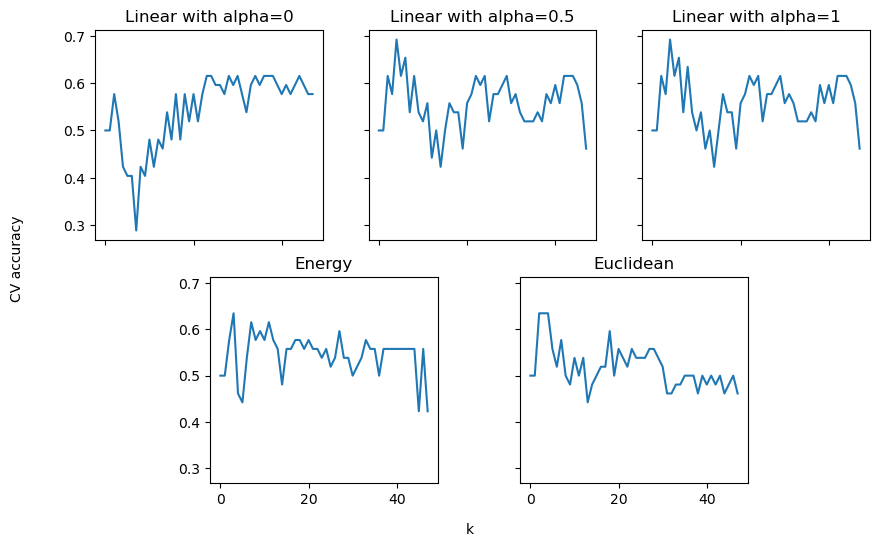

In [723]:
fig, ax= plt.subplots(2,3, figsize=(10,6),sharex=True, sharey=True)
ax[1][2].set_visible(False)
ax[1][0].set_position([0.24,0.125,0.228,0.343])
ax[1][1].set_position([0.55,0.125,0.228,0.343])

ax[0][0].plot(zero_knn_scores)
ax[0][0].set_title("Linear with alpha=0")
ax[0][1].plot(half_knn_scores)
ax[0][1].set_title("Linear with alpha=0.5")
ax[0][2].plot(full_knn_scores)
ax[0][2].set_title("Linear with alpha=1")


ax[1][0].plot(energy_knn_scores)
ax[1][0].set_title("Energy")

ax[1][1].set_title("Euclidean")
ax[1][1].plot(euclid_knn_score)

fig.text(0.5, 0.04, 'k', ha='center')
fig.text(0.04, 0.5, 'CV accuracy', va='center', rotation='vertical')


In [ ]:
f

# MDS linear regression

In [ ]:
zero_mds_scores=[]
for i in range(1, 100):
    mds=MDS(n_components=i,dissimilarity="precomputed")
    points=mds.fit_transform(dist_mat_null)
    lr=LogisticRegression()
    scores = cross_val_score(lr, points, y, cv=26)
    zero_mds_scores.append(np.mean(scores))

In [449]:
np.argmax(zero_mds_scores)

28

In [450]:
np.max(zero_mds_scores)

0.6538461538461539

In [ ]:
half_mds_scores=[]
for i in range(1, 100):
    mds=MDS(n_components=i,dissimilarity="precomputed")
    points=mds.fit_transform(dist_mat_half)
    lr=LogisticRegression()
    scores = cross_val_score(lr, points, y, cv=26)
    half_mds_scores.append(np.mean(scores))

In [462]:
np.max(half_mds_scores)

0.7115384615384616

In [463]:
np.argmax(half_mds_scores)

15

In [ ]:
full_mds_scores=[]
for i in range(1, 100):
    mds=MDS(n_components=i,dissimilarity="precomputed")
    points=mds.fit_transform(dist_mat_full)
    lr=LogisticRegression()
    scores = cross_val_score(lr, points, y, cv=26)
    full_mds_scores.append(np.mean(scores))

In [466]:
np.max(full_mds_scores)

0.6923076923076923

In [467]:
np.argmax(full_mds_scores)

13

In [ ]:
euclid_mds_scores=[]
for i in range(1, 100):
    mds=MDS(n_components=i,dissimilarity="precomputed")
    points=mds.fit_transform(euclid_dist_m)
    lr=LogisticRegression()
    scores = cross_val_score(lr, points, y, cv=26)
    euclid_mds_scores.append(np.mean(scores))

In [726]:
np.max(euclid_mds_scores)

0.5

In [727]:
np.argmax(euclid_mds_scores)

0

In [ ]:
energy_mds_score=[]
for i in range(1, 100):
    mds=MDS(n_components=i,dissimilarity="precomputed")
    points=mds.fit_transform(dist_m_2)
    lr=LogisticRegression()
    scores = cross_val_score(lr, points, y, cv=26)
    energy_mds_score.append(np.mean(scores))

In [694]:
np.argmax(energy_mds_score)

47

In [695]:
np.max(energy_mds_score)

0.8076923076923077

Text(0.04, 0.5, 'CV accuracy')

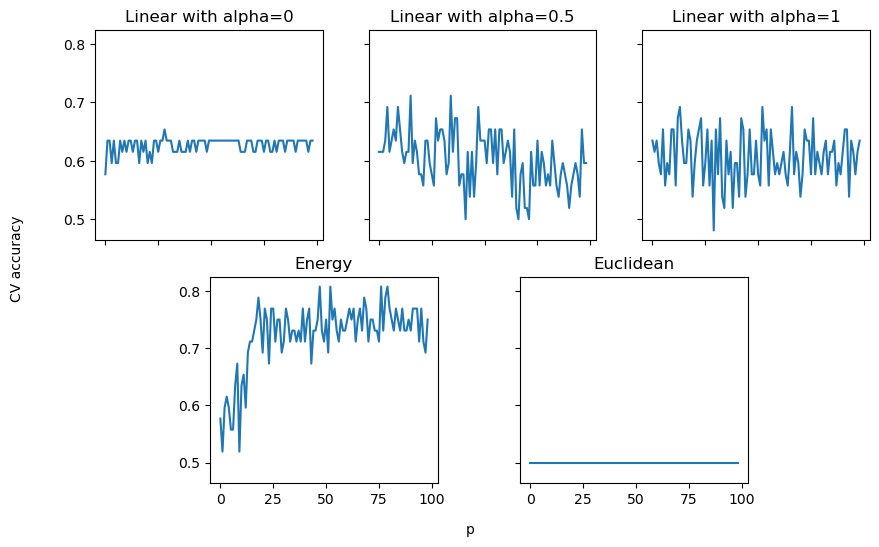

In [724]:
fig, ax= plt.subplots(2,3, figsize=(10,6),sharex=True, sharey=True)
ax[1][2].set_visible(False)
ax[1][0].set_position([0.24,0.125,0.228,0.343])
ax[1][1].set_position([0.55,0.125,0.228,0.343])

ax[0][0].plot(zero_mds_scores)
ax[0][0].set_title("Linear with alpha=0")
ax[0][1].plot(half_mds_scores)
ax[0][1].set_title("Linear with alpha=0.5")
ax[0][2].plot(full_mds_scores)
ax[0][2].set_title("Linear with alpha=1")


ax[1][0].plot(energy_mds_score)
ax[1][0].set_title("Energy")

ax[1][1].set_title("Euclidean")
ax[1][1].plot(euclid_mds_scores)

fig.text(0.5, 0.04, 'p', ha='center')
fig.text(0.04, 0.5, 'CV accuracy', va='center', rotation='vertical')
